## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('/kaggle/input/')
path.ls()


[PosixPath('/kaggle/input/train-tif-v2'),
 PosixPath('/kaggle/input/sample_submission_v2.csv'),
 PosixPath('/kaggle/input/train-jpg'),
 PosixPath('/kaggle/input/test_v2_file_mapping.csv'),
 PosixPath('/kaggle/input/test-tif-v3'),
 PosixPath('/kaggle/input/test-jpg-v2'),
 PosixPath('/kaggle/input/train_v2.csv')]

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [6]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [7]:
ImageList??


In [8]:
data = (src.transform(tfms, size=128)
        .databunch(num_workers=0).normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

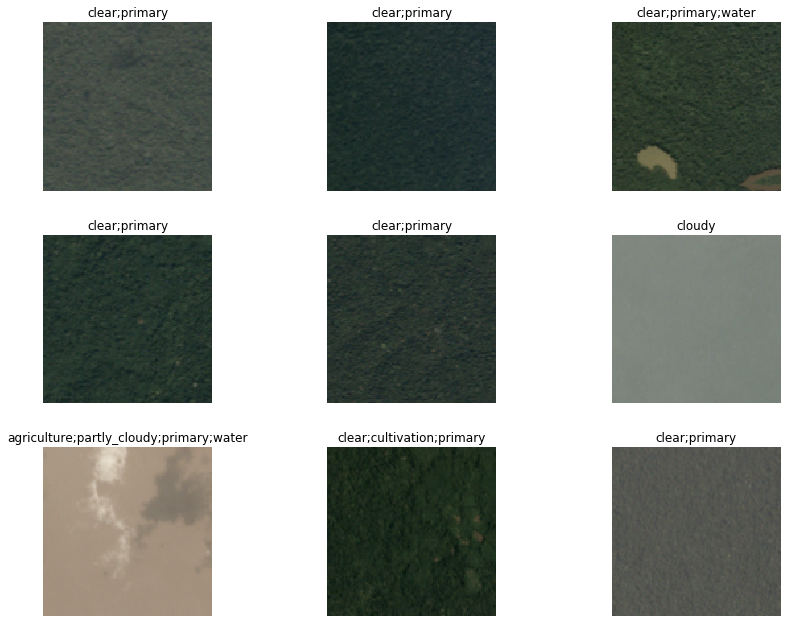

In [9]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [10]:
arch = models.resnet50

In [11]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score], model_dir='/tmp/models')

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 19264069.02it/s]


We use the LR Finder to pick a good learning rate.

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


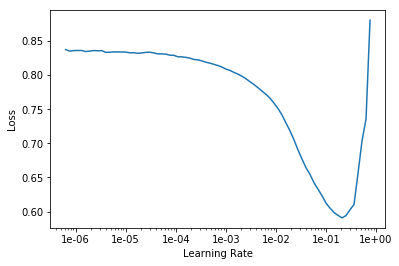

In [13]:
learn.recorder.plot()

Then we can fit the head of our network.

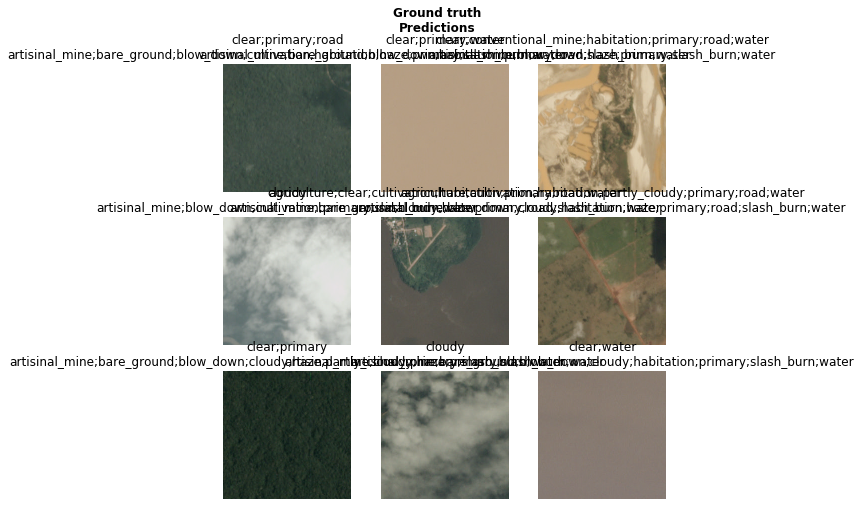

In [14]:
learn.show_results(rows=3, figsize=(8,8))
lr = 0.01

In [15]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124778,0.109522,0.945035,0.900410,03:40
1,0.110003,0.099930,0.945318,0.912008,03:28
2,0.102972,0.092527,0.957897,0.919279,03:26
3,0.096442,0.087331,0.953450,0.923613,03:25
4,0.092441,0.086815,0.956662,0.924013,03:26


In [16]:
learn.save('stage-1-rn50')

In [17]:
interp = ClassificationInterpretation.from_learner(learn)


In [18]:
interp.top_losses()


torch.return_types.topk(
values=tensor([11.5976,  9.6615,  9.1910,  ...,  0.0000,  0.0000,  0.0000]),
indices=tensor([86430, 15309, 62190,  ...,  5339, 39475, 63094]))

In [19]:
len(data.valid_ds)==len(losses)==len(idxs)


NameError: name 'losses' is not defined

In [20]:
print(data.classes)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


...And fine-tune the whole model:

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


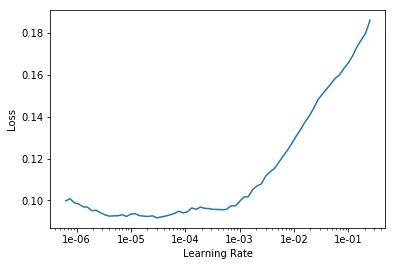

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097773,0.091997,0.954518,0.917740,03:43
1,0.095377,0.091745,0.958159,0.919211,03:43
2,0.090296,0.085628,0.956873,0.927111,03:43
3,0.085590,0.082798,0.957374,0.928390,03:44
4,0.081945,0.082395,0.959329,0.929636,03:44


In [24]:
learn.save('stage-2-rn50')

In [25]:
data = (src.transform(tfms, size=256)
        .databunch(num_workers=0).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [26]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


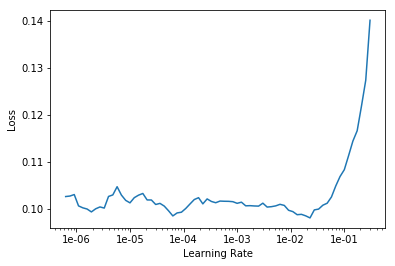

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
lr=1e-2/2

In [29]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.089261,0.085087,0.954416,0.926009,07:16
1,0.088526,0.084699,0.958914,0.925906,07:15
2,0.086407,0.082035,0.957839,0.928992,07:15
3,0.083617,0.081355,0.959547,0.930048,07:15
4,0.079901,0.080868,0.959416,0.930809,07:16


In [30]:
learn.save('stage-1-256-rn50')

In [31]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086138,0.082991,0.958922,0.928937,08:11
1,0.083950,0.084267,0.958122,0.928030,08:10
2,0.082370,0.082660,0.957599,0.928909,08:10
3,0.078510,0.081235,0.958740,0.929937,08:10
4,0.073809,0.081162,0.958253,0.929929,08:10


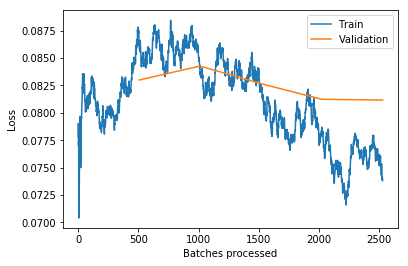

In [33]:
learn.recorder.plot_losses()

In [34]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [35]:
learn.export()

OSError: [Errno 30] Read-only file system: '/kaggle/input/export.pkl'

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [36]:
test = ImageItemList.from_folder(path/'test-jpg').add(ImageItemList.from_folder(path/'test-jpg-additional'))
len(test)

NameError: name 'ImageItemList' is not defined

In [37]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

NameError: name 'test' is not defined

In [38]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

NameError: name 'preds' is not defined

In [39]:
labelled_preds[:5]

NameError: name 'labelled_preds' is not defined

In [40]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

AttributeError: 'NoneType' object has no attribute 'items'

In [41]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

NameError: name 'fnames' is not defined

In [42]:
df.to_csv(path/'submission.csv', index=False)

OSError: [Errno 30] Read-only file system: '/kaggle/input/submission.csv'

Private Leaderboard score: 0.9296 (around 80th)